# Visualize best RFE conformations using cMDS plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../..')
from helper_modules.run_or_load import *
from helper_modules.MDS import *

In [2]:
prot_name = 'cdk2'

In [3]:
DIR = '../1_Download_and_prepare_protein_ensembles'
path_to_file = f'{DIR}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)

In [4]:
df_dims = pd.read_pickle('../3_Protein_Ensembles_Analysis/df_PROTEINS_DIMS_reduced_TABLE.obj')
# update the df with the mds axis
# Pocket shape
df_prot['vol_x'] = df_dims['mds_vol_pkt_x']
df_prot['vol_y'] = df_dims['mds_vol_pkt_y']
# secondary structure residues RMSD
df_prot['secres_x'] = df_dims['mds_sec_x']
df_prot['secres_y'] = df_dims['mds_sec_y']
# pocket residues RMSD
df_prot['pkt_x'] = df_dims['mds_pkt_x']
df_prot['pkt_y'] = df_dims['mds_pkt_y']

In [5]:
# Extra features to get volume or surface area
df_extra = pd.read_pickle(f'../4_Ensemble_docking_results/TABLE_Confs_Features_and_performances_cdk2.pkl')

# Adding to the main df
df_prot['volume'] = df_extra['Pk. Volume']
df_prot['surf_area'] = df_extra['Pk. SASA']

# ROC-AUC single performance
df_prot['AUC-ROC'] = df_extra['AUC-ROC']

In [6]:
df_dims = pd.read_pickle(f'../3_Protein_Ensembles_Analysis/df_PROTEINS_DIMS_reduced_TABLE.obj')
df_dims.head()

,mds_sec_x,mds_sec_y,mds_pkt_x,mds_pkt_y,mds_vol_pkt_x,mds_vol_pkt_y
1aq1,0.501509,0.222951,-0.005096,0.078283,-0.037282,0.068246
1b38,0.498571,-0.190066,-0.147425,-0.133837,0.057118,-0.151794
1b39,0.590926,-0.188395,-0.090472,-0.120499,0.058764,-0.139097
1buh,0.469080,-0.331782,-0.462360,-0.329224,0.014419,-0.216752
1ckp,0.498563,-0.211226,-0.416171,-0.165842,0.035167,0.038303


In [7]:
# *******************
# Pocket Residues 
# *******************

# update the df with the mds axis
df_prot['x'] = df_dims['mds_pkt_x']
df_prot['y'] = df_dims['mds_pkt_y']

In [8]:
# Open RFE_estimator
# Open RFE_estimator
dataset    = 'MERGED'
model_name = 'XGB_tree'
split      = 'random'
filename   = f'./cachedir/rfe_selectors/RFE_xgb_{prot_name}.joblib'
# Load the RFE selector (computed in the previos notebook)
rfe_selector = joblib.load(filename)
# Create a dataframe with the protein rankings
df_ranks     = pd.DataFrame({
                     'pdb_id'     : df_prot.index, 
                     'rfe_ranking': rfe_selector.ranking_
               })
df_ranks     = df_ranks.sort_values('rfe_ranking').set_index('pdb_id')

# update the df with the rank values
df_prot = df_prot.merge(df_ranks, left_index=True, right_index=True)\
            .sort_values('rfe_ranking')

In [9]:
# To be able to plot confs with no inhibitors => NA == 10
df_prot['Inhib_mass_num'] = pd.to_numeric(df_prot['Inhib_mass']).\
                        fillna(10) ** 2
df_prot['volume.T'] = (df_prot['volume']/100) ** 1.5

In [10]:
df_selected = df_prot.sort_values('rfe_ranking').head(16)
x = 'vol_x'
y = 'vol_y'
size='volume.T'


In [11]:
%load_ext rpy2.ipython

In [12]:
df_to_R = df_prot[['rfe_ranking', 'vol_x', 'vol_y', 'volume']]
df_to_R

,rfe_ranking,vol_x,vol_y,volume
4bzd,1,0.073413,0.146152,739.0
2r64,2,0.048355,0.049173,775.0
3unk,3,0.123780,0.094126,654.0
4d1z,4,-0.191442,0.103834,972.0
2iw8,5,-0.054893,0.116523,844.0
...,...,...,...,...
2vtr,398,0.041665,0.006647,771.0
2r3n,399,0.077959,-0.089652,567.0
3qzh,400,0.106990,0.051550,772.0
3wbl,401,0.093861,-0.036437,729.0


R[write to console]: ── Attaching packages ───────────────────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ──────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



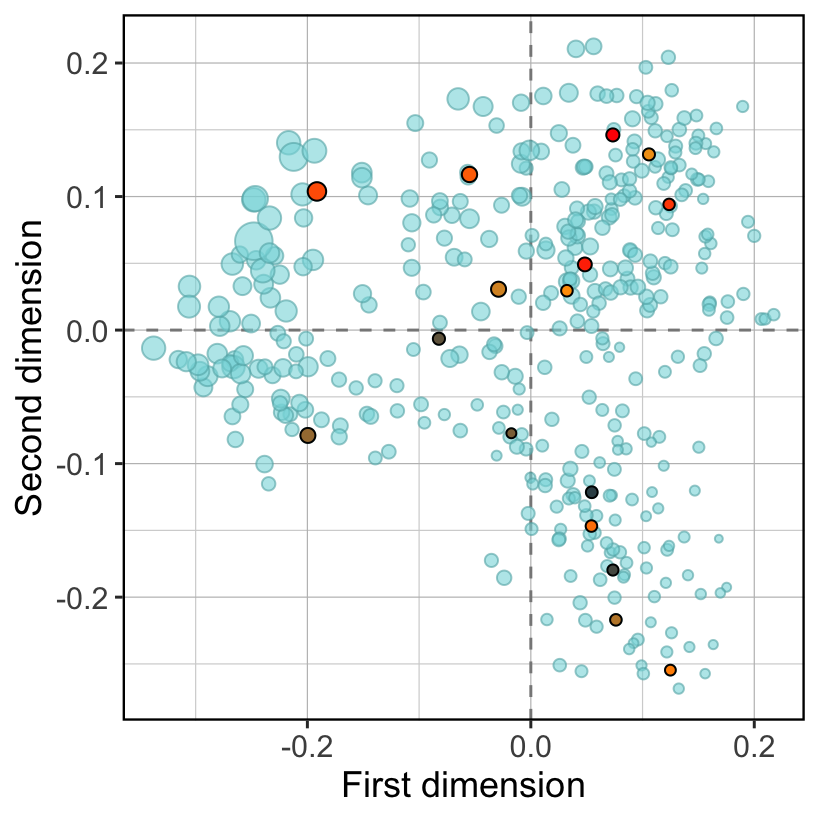

In [13]:
%%R -i df_to_R -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)


df <- df_to_R %>% 
    mutate(volume.T = (volume / 100) **2 )
top_4 <- 4
top_16 <- 16

p = ggplot() +
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=vol_x, y=vol_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=vol_x, y=vol_y,
                           size=volume.T, 
                fill=rfe_ranking),
                color='black',
                shape=21, stroke=0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +

    theme(legend.position = 'none', 
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')

p

## Swarplot with the auc values

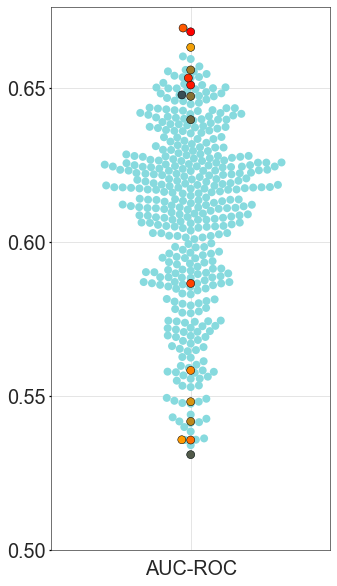

In [14]:
import matplotlib.ticker as ticker
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=["red", "orange", "#374E55"],
    N=16
)
matplotlib.cm.register_cmap("mycolormap", cmap)
sns.set(font_scale=1.8, style='whitegrid')

df_ = df_prot.copy()
df_['top_mask'] = [3 if i <= 4 else 2 if i <= 16 else 1 for i in df_['rfe_ranking']]
df_ = df_[['AUC-ROC', 'top_mask', 'rfe_ranking']].melt(id_vars=('top_mask', 'rfe_ranking'))

fig, ax = plt.subplots(figsize=(5, 10))
# Blue dots
np.random.seed(2)
sns.swarmplot(y='value', x='variable', size=8,
              data=df_, ax=ax,
              color='#87DADE')
# top 16
df_top = df_.query('top_mask > 1') 
np.random.seed(2)
sns.swarmplot(y='value', x='variable', size=8,
              data=df_top, ax=ax,
              hue='rfe_ranking',
              edgecolor='black', linewidth=0.5,
              palette='mycolormap')
# ax.set_ylim((0.49, 0.7))
ax.set_yticks(np.arange(0.5, 0.70, .05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.tick_left()
ax.get_legend().remove()
ax.tick_params(length=2, color='black', axis='y')
ax.grid(True, linewidth=0.5)
ax.set(xlabel='', ylabel='')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    ax.spines[axis].set_edgecolor('black')
plt.show()

## MDS using Secondary structure

In [15]:
df_to_R_sec = df_prot[['rfe_ranking', 'secres_x', 'secres_y', 'volume']]

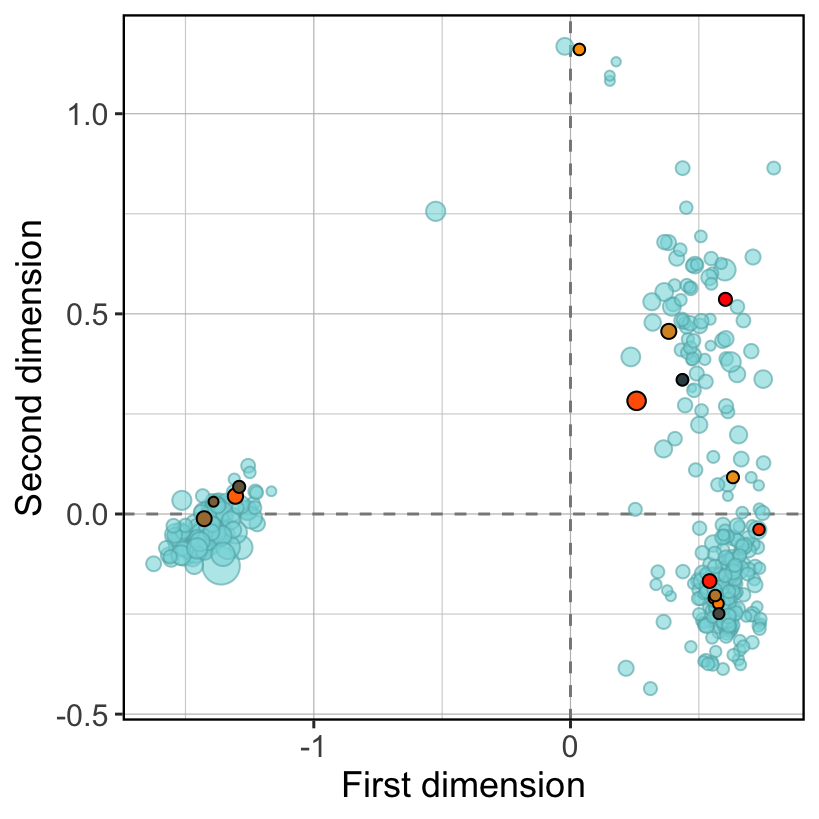

In [16]:
%%R -i df_to_R_sec -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)


df <- df_to_R_sec %>% 
    mutate(volume.T = (volume / 100) **2 )
top_4 <- 4
top_16 <- 16

p = ggplot() +
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=secres_x, y=secres_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=secres_x, y=secres_y,
                           size=volume.T, 
                fill=rfe_ranking),
                color='black',
                shape=21, stroke=0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +

    theme(legend.position = 'none', 
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')


p

## MDS using pocket residues

In [17]:
df_to_R_sec = df_prot[['rfe_ranking', 'pkt_x', 'pkt_y', 'volume']]

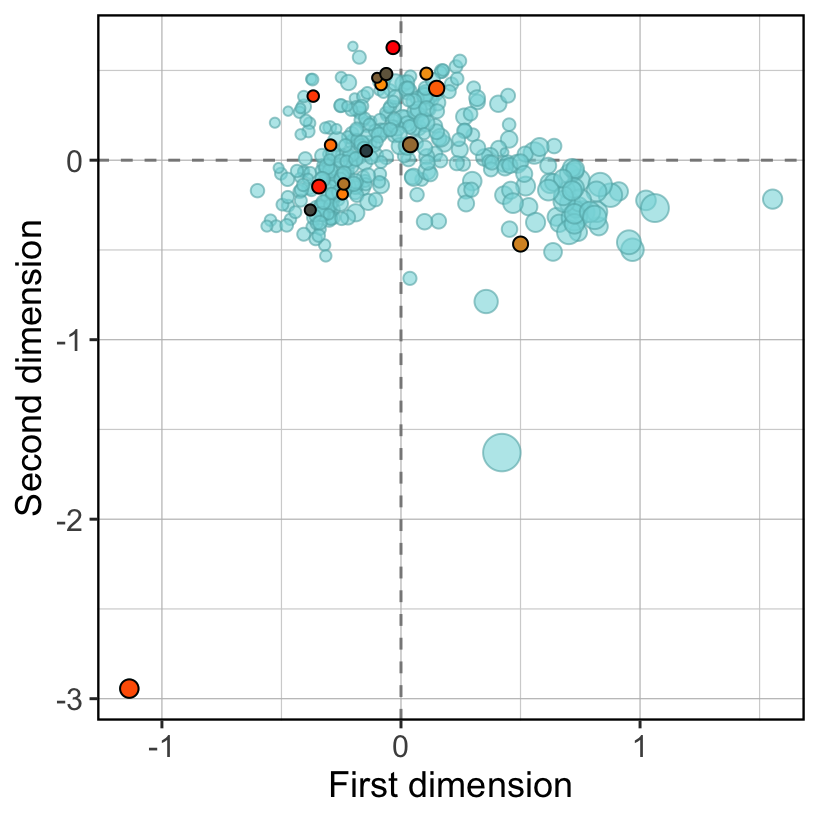

In [18]:
%%R -i df_to_R_sec -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)


df <- df_to_R_sec %>% 
    mutate(volume.T = (volume / 100) **2 )
top_4 <- 4
top_16 <- 16

p = ggplot() +
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=pkt_x, y=pkt_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=pkt_x, y=pkt_y,
                           size=volume.T, 
                fill=rfe_ranking),
                color='black',
                shape=21, stroke=0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +

    theme(legend.position = 'none', 
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')


p